# Submission by:
#### Fahad Maqsood
#### Dated: 28-12-2021

# Task 1: Data Engineering
*********************************************

# Initializiation and Importing all the necessary Modules and Libraries

In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import findspark
findspark.init()
findspark.find()
import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.types import * 
from pyspark.sql.functions import *

import pandas 


conf = pyspark.SparkConf().setAppName('Daimler Programming_Challange').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlcontext=SQLContext(sc)

In [2]:
# Testing Creation of a Spark Session
spark

## 1- Loading Data/Data Extraction  


In [3]:
# Extracting Excel sheets sales_codes, vehicle_hash and engines from vehicle_data.xlsx
sales_codes = pandas.read_excel('vehicle_data.xlsx', sheet_name='sales_codes', inferSchema=True)
vehicle_hash = pandas.read_excel('vehicle_data.xlsx', sheet_name='vehicle_hash', inferSchema=True)
engines = pandas.read_excel('vehicle_data.xlsx', sheet_name='engines', inferSchema=True)

# Conversion of excel sheets to csv files with their respective names
sales_codes.to_csv('sales_codes.csv', encoding='utf-8')
vehicle_hash.to_csv('vehicle_hash.csv', encoding='utf-8')
engines.to_csv('engines.csv', encoding='utf-8')

# Output:  sales_codes.csv, vehicle_hash.csv, engines.csv created.
# Check if the DATA is READY for further processing

#### Creating Spark Dataframes from the csv files  

In [4]:
# Loading data from the csv files into the dataframes of the same name
sales_codes_df=spark.read.csv('sales_codes.csv',inferSchema=True,header=True)
vehicle_hash_df=spark.read.csv('vehicle_hash.csv',inferSchema=True,header=True)
engines_df=spark.read.csv('engines.csv',inferSchema=True,header=True)

In [5]:
# Displaying the dataframes with schemas
sales_codes_df.show(5)
vehicle_hash_df.show(5)
engines_df.show(5)
sales_codes_df.printSchema()
vehicle_hash_df.printSchema()
engines_df.printSchema()

+---+----------+--------------------+-------------------+---------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|    production_date|  country|    sales_code_array|
+---+----------+--------------------+-------------------+---------+--------------------+
|  0|         0|924d229bede272c5a...|2013-02-05 00:00:00|  Namibia|Z5E, M3E, A4S, Y1...|
|  1|         0|3787a8db036dabd74...|2012-08-27 00:00:00|  Germany|Z5D, M2N, K1X, Q2...|
|  2|         0|aea31cdf4f575acf1...|2015-08-11 00:00:00|  Germany|Z5C, M2A, A5H, P7...|
|  3|         0|d92ed338496281e08...|2015-02-22 00:00:00|Lithuania|Z5F, M3P, D3H, C8...|
|  4|         0|7934c4872515da4b1...|2017-03-10 00:00:00|  Germany|Z5B, M1K, L1T, E6...|
+---+----------+--------------------+-------------------+---------+--------------------+
only showing top 5 rows

+---+----------+--------------------+-----------------+-------------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|              fin|record_source|             l

### Initial Data Analysis and Observations

#### Testing Data and Looking for corrupt values and errors

In [6]:
# Overview of Dataframes before cleaning
sales_codes_df.describe().show()
vehicle_hash_df.describe().show()

+-------+-----------------+----------+--------------------+-------------------+-----------+--------------------+
|summary|              _c0|Unnamed: 0|      h_vehicle_hash|    production_date|    country|    sales_code_array|
+-------+-----------------+----------+--------------------+-------------------+-----------+--------------------+
|  count|              500|       500|                 495|                497|        490|                 500|
|   mean|            249.5|       0.0|                null|               null|       null|                null|
| stddev|144.4818327679989|       0.0|                null|               null|       null|                null|
|    min|                0|         0|00cb7b6fc44b7d6cd...|         05.06.1899|Afghanistan|Z5B, M1H, D2H, S5...|
|    max|              499|         0|fff5e3b57e4637489...|9999-05-12 00:00:00|      Yemen|Z5L, M3M, Z8P, R5...|
+-------+-----------------+----------+--------------------+-------------------+-----------+-----

#### Notes
* Presence of NULL/undefined values in sales code dataframe, no null found in vehicle_hash_df and engines_df
* faulty dates in "production_dates" column in sales_code_df , "fin" in vehicle_hash_df

In [7]:
# looking for entries which don't follow the vehicle ID format. RegEx:^[A-Z](\d|\w)[A-Z]\d{14}
vehicle_hash_df.where(~vehicle_hash_df["fin"].rlike("^[A-Z](\d|\w)[A-Z]\d{14}")).show()

+---+----------+--------------------+----------------+-------------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|             fin|record_source|             load_ts|
+---+----------+--------------------+----------------+-------------+--------------------+
| 86|         0|b820055eeacc6767f...|NMB7057091351743|        vedoc|2021-11-26 12:22:...|
|115|         0|b23b13902d1cd36b3...|         NM97254|        vedoc|2021-11-26 12:22:...|
|144|         0|d7dc551dbd7311612...|               W|        vedoc|2021-11-26 12:22:...|
|166|         0|920605e523c7c51a6...|  42328400461785|        vedoc|2021-11-26 12:22:...|
|457|         0|9196d2b34cdc15cb8...|MB60225250190773|        vedoc|2021-11-26 12:22:...|
|494|         0|638b2c1128f0ac139...|           WEB46|        vedoc|2021-11-26 12:22:...|
+---+----------+--------------------+----------------+-------------+--------------------+



In [8]:
# Looking for Corrupt data in the production_date column in Sales codes dataframe
sales_codes_df.groupBy(year(sales_codes_df["production_date"])).count().show()

+---------------------+-----+
|year(production_date)|count|
+---------------------+-----+
|                 2018|   44|
|                 2015|   48|
|                 2013|   47|
|                 null|    6|
|                 2014|   44|
|                 2019|   37|
|                 1910|    1|
|                 2020|   30|
|                 2012|   56|
|                 2055|    1|
|                 2016|   47|
|                 9999|    1|
|                 9080|    1|
|                 2011|   66|
|                 2017|   52|
|                 2021|   19|
+---------------------+-----+



In [9]:
# Looking for NULL values in the sales codes dataframe
sales_codes_df.where(sales_codes_df["production_date"].isNull()\
                    | sales_codes_df["country"].isNull()\
                    | sales_codes_df["h_vehicle_hash"].isNull()\
                    | sales_codes_df["sales_code_array"].isNull()).show()

+---+----------+--------------------+-------------------+--------------------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|    production_date|             country|    sales_code_array|
+---+----------+--------------------+-------------------+--------------------+--------------------+
| 26|         0|2cabda59cb5d6444a...|2013-08-10 00:00:00|                null|Z5F, M3V, M0S, U8...|
| 69|         0|4a9d1bfa9442b27ee...|2012-01-31 00:00:00|                null|Z5L, M3L, S5E, X3...|
| 88|         0|2b094a712b6bc8a45...|2014-01-25 00:00:00|                null|Z5L, M3L, Y4S, C0...|
|110|         0|cdf6699b58773197d...|2011-09-21 00:00:00|                null|Z5F, M3N, X1L, I5...|
|163|         0|                null|2019-11-30 00:00:00|         Philippines|Z5D, M2N, A2Z, X4...|
|175|         0|eee060a19ccfce166...|2018-02-18 00:00:00|                null|Z5E, M3D, Z2R, N2...|
|220|         0|f711fe5257cfd2c90...|2016-11-18 00:00:00|                null|Z5C, M2C, Q9Y, Z0...|


In [10]:
# Looking for country names that don't follow the formatting
# First letter Capital followed by small characters, RegEx: ^[A-Z][a-z].{0,50}
# check
sales_codes_df.filter(~sales_codes_df["country"].rlike("^[A-Z][a-z].{0,50}")).show()

+---+----------+--------------------+-------------------+---------+--------------------+
|_c0|Unnamed: 0|      h_vehicle_hash|    production_date|  country|    sales_code_array|
+---+----------+--------------------+-------------------+---------+--------------------+
|397|         0|2896855941ad1b044...|2011-05-25 00:00:00|GIBRALTAR|Z5L, M3J, C4B, D3...|
|402|         0|c0dc21ff18421f39b...|2012-07-10 00:00:00|GIBRALTAR|Z5F, M3N, T1D, Q3...|
|406|         0|19245e9fc3b29d054...|2018-12-13 00:00:00|GIBRALTAR|Z5D, M2S, K4E, K1...|
+---+----------+--------------------+-------------------+---------+--------------------+



#### Observation Notes:

* Presence of un-necessary columns which should be removed.
  
* Vehicle ID "fin" is a unique ID comprised of capital alphabets and numerals and follows a specific format. Those entries have to be removed which don't correspond to the ID format.

* Data types of some columns has to be rectified e.g. "production_date" should be DATE type. 

* Production Dates of some vehicles have corrupt values e.g. 9999/01/01.

* Format of country name should be a capital letter followed by small alphabets.

* "Sales_code_array" is just a string whereas it should be an array with string element type. 

* Furthermore, it should be taken into consideration that a vehicle/truck is driven by ONE engine only. If the composition of truck(Sales_code_array) is comprised of two or more engines then that particular entry has to removed.

* Rows with NULL/undefined values has to be removed.

##  2- Data Cleaning and Data Preparation 

### Data has to be cleaned and processed  
*************************************************************************************************************************

In [11]:
# Removing the additional columns 
sales_codes_df=sales_codes_df.drop("_c0","Unnamed: 0")
vehicle_hash_df=vehicle_hash_df.drop("_c0","Unnamed: 0")
engines_df=engines_df.drop("_c0")


In [12]:
# test and check for updated cols
sales_codes_df.show(3)
vehicle_hash_df.show(3)
engines_df.show(3)

+--------------------+-------------------+-------+--------------------+
|      h_vehicle_hash|    production_date|country|    sales_code_array|
+--------------------+-------------------+-------+--------------------+
|924d229bede272c5a...|2013-02-05 00:00:00|Namibia|Z5E, M3E, A4S, Y1...|
|3787a8db036dabd74...|2012-08-27 00:00:00|Germany|Z5D, M2N, K1X, Q2...|
|aea31cdf4f575acf1...|2015-08-11 00:00:00|Germany|Z5C, M2A, A5H, P7...|
+--------------------+-------------------+-------+--------------------+
only showing top 3 rows

+--------------------+-----------------+-------------+--------------------+
|      h_vehicle_hash|              fin|record_source|             load_ts|
+--------------------+-----------------+-------------+--------------------+
|924d229bede272c5a...|WEB14561113188001|        vedoc|2021-11-26 12:22:...|
|3787a8db036dabd74...|W1T61600516560507|        vedoc|2021-11-26 12:22:...|
|aea31cdf4f575acf1...|WEB74212637167838|        vedoc|2021-11-26 12:22:...|
+--------------

#### Note:
Irrelevant columns removed.

In [13]:
# Cleaning the Entries in vehicle ID "fin" column
# Using Regular Expression to clean data in the vehicle ID "fin" column
# vehicle id has a specific pattern which can be encoded as regular expression/RegEx
# RegEXP has the following sequence: Character,Digit/Character,Character,followed by 14 digits
vehicle_hash_df=vehicle_hash_df.filter(vehicle_hash_df["fin"].rlike("^[A-Z](\d|\w)[A-Z]\d{14}"))
vehicle_hash_df.printSchema()
vehicle_hash_df.show(3)
vehicle_hash_df.count()

root
 |-- h_vehicle_hash: string (nullable = true)
 |-- fin: string (nullable = true)
 |-- record_source: string (nullable = true)
 |-- load_ts: string (nullable = true)

+--------------------+-----------------+-------------+--------------------+
|      h_vehicle_hash|              fin|record_source|             load_ts|
+--------------------+-----------------+-------------+--------------------+
|924d229bede272c5a...|WEB14561113188001|        vedoc|2021-11-26 12:22:...|
|3787a8db036dabd74...|W1T61600516560507|        vedoc|2021-11-26 12:22:...|
|aea31cdf4f575acf1...|WEB74212637167838|        vedoc|2021-11-26 12:22:...|
+--------------------+-----------------+-------------+--------------------+
only showing top 3 rows



494

#### Note:
corrupt vehicle ID's "fin" have been removed

In [14]:
# Correcting the datatypes of columns in sales_codes_df and vehicle_hash_df dataframes
# Normalizing the data type in "production_date" column

sales_codes_df=sales_codes_df.withColumn("production_date",to_date("production_date"))
vehicle_hash_df=vehicle_hash_df.withColumn("load_ts",to_date("load_ts"))
sales_codes_df.show(5)
vehicle_hash_df.show(5)

sales_codes_df.printSchema()
vehicle_hash_df.printSchema()

+--------------------+---------------+---------+--------------------+
|      h_vehicle_hash|production_date|  country|    sales_code_array|
+--------------------+---------------+---------+--------------------+
|924d229bede272c5a...|     2013-02-05|  Namibia|Z5E, M3E, A4S, Y1...|
|3787a8db036dabd74...|     2012-08-27|  Germany|Z5D, M2N, K1X, Q2...|
|aea31cdf4f575acf1...|     2015-08-11|  Germany|Z5C, M2A, A5H, P7...|
|d92ed338496281e08...|     2015-02-22|Lithuania|Z5F, M3P, D3H, C8...|
|7934c4872515da4b1...|     2017-03-10|  Germany|Z5B, M1K, L1T, E6...|
+--------------------+---------------+---------+--------------------+
only showing top 5 rows

+--------------------+-----------------+-------------+----------+
|      h_vehicle_hash|              fin|record_source|   load_ts|
+--------------------+-----------------+-------------+----------+
|924d229bede272c5a...|WEB14561113188001|        vedoc|2021-11-26|
|3787a8db036dabd74...|W1T61600516560507|        vedoc|2021-11-26|
|aea31cdf4f575a

#### Note
Datatypes of production_date and load_ts have been updated.

In [15]:
# Removing entries with false dates
# data has values like 9999,2055,9080 as year of production
sales_codes_df=sales_codes_df.filter((year(sales_codes_df.production_date)<=2021)\
                                           & (year(sales_codes_df.production_date)>=1998))

In [16]:
# Test
sales_codes_df.groupBy(year(sales_codes_df["production_date"])).count().show()

+---------------------+-----+
|year(production_date)|count|
+---------------------+-----+
|                 2018|   44|
|                 2015|   48|
|                 2013|   47|
|                 2014|   44|
|                 2019|   37|
|                 2020|   30|
|                 2012|   56|
|                 2016|   47|
|                 2011|   66|
|                 2017|   52|
|                 2021|   19|
+---------------------+-----+



#### Note
Corrupt dates in production_date have been removed and sales_code_df updated

In [17]:
# Applying the format for country names (first alphabet capital and rest are small aplhabets)
sales_codes_df=sales_codes_df.withColumn("country",initcap(sales_codes_df["country"]))

# Test and check updated dataframe
sales_codes_df.where(sales_codes_df["country"]=="Gibraltar").show()

+--------------------+---------------+---------+--------------------+
|      h_vehicle_hash|production_date|  country|    sales_code_array|
+--------------------+---------------+---------+--------------------+
|2896855941ad1b044...|     2011-05-25|Gibraltar|Z5L, M3J, C4B, D3...|
|c0dc21ff18421f39b...|     2012-07-10|Gibraltar|Z5F, M3N, T1D, Q3...|
|19245e9fc3b29d054...|     2018-12-13|Gibraltar|Z5D, M2S, K4E, K1...|
+--------------------+---------------+---------+--------------------+



#### Note:
Formatting applied to the country names in the "country" column in sales_codes_df

In [18]:
# Normalizing the Data type of "sales_code_array"
sales_codes_df=sales_codes_df.withColumn("sales_code_array",split("sales_code_array",", "))

# Test
sales_codes_df.printSchema()
sales_codes_df.show(3)


root
 |-- h_vehicle_hash: string (nullable = true)
 |-- production_date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- sales_code_array: array (nullable = true)
 |    |-- element: string (containsNull = true)

+--------------------+---------------+-------+--------------------+
|      h_vehicle_hash|production_date|country|    sales_code_array|
+--------------------+---------------+-------+--------------------+
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|
|3787a8db036dabd74...|     2012-08-27|Germany|[Z5D, M2N, K1X, Q...|
|aea31cdf4f575acf1...|     2015-08-11|Germany|[Z5C, M2A, A5H, P...|
+--------------------+---------------+-------+--------------------+
only showing top 3 rows



#### Note:
Normalized the data-type of "sales_code_array" : an array with string elements 

In [19]:
# check if sales_code_array has sales code of multiple engines,
# we use engine_df here to join the two dataframes based on "sales code" as the key
# Exploding the sales code array to see all the sales codes against a single vehicle ID
sales_codes_df=sales_codes_df.withColumn("vehicle_comp",explode(sales_codes_df.sales_code_array))
sales_codes_df.show()


+--------------------+---------------+-------+--------------------+------------+
|      h_vehicle_hash|production_date|country|    sales_code_array|vehicle_comp|
+--------------------+---------------+-------+--------------------+------------+
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         Z5E|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         M3E|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         A4S|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         Y1R|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         F5E|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         J3Y|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         X4M|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         J1Z|
|924d229bede272c5a...|     2013-02-05|Namibia|[Z5E, M3E, A4S, Y...|         M5X|
|924d229bede272c5a...|     2

In [20]:
sales_codes_df=sales_codes_df.join(engines_df,sales_codes_df["vehicle_comp"]==engines_df["Sales Code"],"inner")
sales_codes_df.columns

['h_vehicle_hash',
 'production_date',
 'country',
 'sales_code_array',
 'vehicle_comp',
 'Code Group Id',
 'Code Group Name En ',
 'Code Group Name De ',
 'Folder Name',
 'Sales Code',
 'Code Description En',
 'Code Description De']

In [21]:
# for a better description
sales_codes_df=sales_codes_df.select("h_vehicle_hash","production_date","country","sales_code_array",\
                      "vehicle_comp","Sales Code","Code Description En")


In [22]:
sales_codes_df=sales_codes_df.groupBy("h_vehicle_hash","production_date","country","sales_code_array")\
.agg(concat_ws(', ',collect_set("Sales Code")).alias("Engine Sales Code")\
     ,concat_ws(', ',collect_set("Code Description En")).alias("Engines used"))
sales_codes_df.show()

+--------------------+---------------+--------------------+--------------------+-----------------+--------------+
|      h_vehicle_hash|production_date|             country|    sales_code_array|Engine Sales Code|  Engines used|
+--------------------+---------------+--------------------+--------------------+-----------------+--------------+
|33f4215da96af4dfb...|     2017-12-21|   Serbia Montenegro|[Z5L, M3M, H8U, P...|              Z5L|        OM 460|
|43aba6dfaa7f21b40...|     2015-09-07|              Azores|[Z5E, M3E, E1N, P...|         Z5A, Z5E|M 936G, OM 471|
|5652bc231dd43ca6a...|     2021-04-21|             Germany|[Z5C, M2E, N7W, E...|              Z5C|        OM 936|
|fc036bd4d5409fc9f...|     2019-09-08|             Germany|[Z5B, M1I, R5N, Q...|              Z5B|        OM 934|
|00cb7b6fc44b7d6cd...|     2013-08-04|               Qatar|[Z5C, M2C, O5T, Y...|              Z5C|        OM 936|
|251c5da8b2c0a9dd0...|     2012-11-02|             Germany|[Z5D, M2R, W3Z, Z...|        

In [23]:
# It can be observed that there are vehicles with More than ONE engine which seems unlikely to happen
# Hence we remove those entries with more than one engines
sales_codes_df.where(length(sales_codes_df["Engine Sales Code"])>3).show()

+--------------------+---------------+--------------------+--------------------+-----------------+--------------------+
|      h_vehicle_hash|production_date|             country|    sales_code_array|Engine Sales Code|        Engines used|
+--------------------+---------------+--------------------+--------------------+-----------------+--------------------+
|43aba6dfaa7f21b40...|     2015-09-07|              Azores|[Z5E, M3E, E1N, P...|         Z5A, Z5E|      M 936G, OM 471|
|6cb2a05fa5378a1ff...|     2014-04-05|             Germany|[Z5L, M3M, W2D, W...|         Z5L, M0I|      OM 460, OM 924|
|be9c0425cd927d63e...|     2011-03-06|            Simbabwe|[Z5F, M3N, A2F, V...|         M0I, Z5F|      OM 473, OM 924|
|708cac2bd86d57ed7...|     2018-08-30|             Germany|[Z5L, M3J, F7Q, L...|         Z5A, Z5L|      M 936G, OM 460|
|224a4779c9f5af1c2...|     2011-08-10|             Germany|[Z5C, M2D, Z7Y, R...|         Z5A, Z5C|      M 936G, OM 936|
|37aedebe2b71b332b...|     2013-02-26|  

In [24]:
### Removing those entries which have sales_code_array corresponding to multiple engines in one Vehicle
sales_codes_df=sales_codes_df.where(length(sales_codes_df["Engine Sales Code"])<=3)

# test
sales_codes_df.show()
sales_codes_df.count()

+--------------------+---------------+--------------------+--------------------+-----------------+------------+
|      h_vehicle_hash|production_date|             country|    sales_code_array|Engine Sales Code|Engines used|
+--------------------+---------------+--------------------+--------------------+-----------------+------------+
|33f4215da96af4dfb...|     2017-12-21|   Serbia Montenegro|[Z5L, M3M, H8U, P...|              Z5L|      OM 460|
|5652bc231dd43ca6a...|     2021-04-21|             Germany|[Z5C, M2E, N7W, E...|              Z5C|      OM 936|
|fc036bd4d5409fc9f...|     2019-09-08|             Germany|[Z5B, M1I, R5N, Q...|              Z5B|      OM 934|
|00cb7b6fc44b7d6cd...|     2013-08-04|               Qatar|[Z5C, M2C, O5T, Y...|              Z5C|      OM 936|
|251c5da8b2c0a9dd0...|     2012-11-02|             Germany|[Z5D, M2R, W3Z, Z...|              Z5D|      OM 470|
|75182f7a6a01463f1...|     2018-04-18|              Jordan|[Z5F, M3V, R4P, V...|              Z5F|      

417

#### Note:
Entries which shows multiple engines against one vehicle have been removed and sales_codes_df updated accordingly.

In [25]:
# Checking for NULL/nan values in the data and Removing them
sales_codes_df=sales_codes_df.na.drop("any")
vehicle_hash_df=vehicle_hash_df.na.drop("any")
engines_df=engines_df.na.drop("any")
sales_codes_df.printSchema()
sales_codes_df.show(10)
sales_codes_df.count()

root
 |-- h_vehicle_hash: string (nullable = true)
 |-- production_date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- sales_code_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Engine Sales Code: string (nullable = false)
 |-- Engines used: string (nullable = false)

+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|      h_vehicle_hash|production_date|            country|    sales_code_array|Engine Sales Code|Engines used|
+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|33f4215da96af4dfb...|     2017-12-21|  Serbia Montenegro|[Z5L, M3M, H8U, P...|              Z5L|      OM 460|
|5652bc231dd43ca6a...|     2021-04-21|            Germany|[Z5C, M2E, N7W, E...|              Z5C|      OM 936|
|fc036bd4d5409fc9f...|     2019-09-08|            Germany|[Z5B, M1I, R5N, Q...|              Z5B|      OM 934|
|00cb7b6

404

### Cleaned Dataframes 

In [26]:
# Displays the cleaned dataframes
sales_codes_df.show(10),vehicle_hash_df.show(10)
sales_codes_df.printSchema(),vehicle_hash_df.printSchema()
sales_codes_df.count(),vehicle_hash_df.count()

+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|      h_vehicle_hash|production_date|            country|    sales_code_array|Engine Sales Code|Engines used|
+--------------------+---------------+-------------------+--------------------+-----------------+------------+
|33f4215da96af4dfb...|     2017-12-21|  Serbia Montenegro|[Z5L, M3M, H8U, P...|              Z5L|      OM 460|
|5652bc231dd43ca6a...|     2021-04-21|            Germany|[Z5C, M2E, N7W, E...|              Z5C|      OM 936|
|fc036bd4d5409fc9f...|     2019-09-08|            Germany|[Z5B, M1I, R5N, Q...|              Z5B|      OM 934|
|00cb7b6fc44b7d6cd...|     2013-08-04|              Qatar|[Z5C, M2C, O5T, Y...|              Z5C|      OM 936|
|251c5da8b2c0a9dd0...|     2012-11-02|            Germany|[Z5D, M2R, W3Z, Z...|              Z5D|      OM 470|
|75182f7a6a01463f1...|     2018-04-18|             Jordan|[Z5F, M3V, R4P, V...|              Z5F|      OM 473|
|

(404, 494)

#### Note:
The Dataframes have been cleaned and are ready for further processing.

## 3- Merging the dataframes 
******************************************************************************************************************

In [27]:
# Merging DF with h_vhicle_hash as the key 
merged_vehicle_DF=sales_codes_df.join(vehicle_hash_df,sales_codes_df.h_vehicle_hash == vehicle_hash_df.h_vehicle_hash,"inner")

In [28]:
# Displaying the newly created dataframe
merged_vehicle_DF.show(3,vertical=True)
merged_vehicle_DF.describe().show(20)


-RECORD 0---------------------------------
 h_vehicle_hash    | 33f4215da96af4dfb... 
 production_date   | 2017-12-21           
 country           | Serbia Montenegro    
 sales_code_array  | [Z5L, M3M, H8U, P... 
 Engine Sales Code | Z5L                  
 Engines used      | OM 460               
 h_vehicle_hash    | 33f4215da96af4dfb... 
 fin               | W1T59495989046715    
 record_source     | vedoc                
 load_ts           | 2021-11-26           
-RECORD 1---------------------------------
 h_vehicle_hash    | 5652bc231dd43ca6a... 
 production_date   | 2021-04-21           
 country           | Germany              
 sales_code_array  | [Z5C, M2E, N7W, E... 
 Engine Sales Code | Z5C                  
 Engines used      | OM 936               
 h_vehicle_hash    | 5652bc231dd43ca6a... 
 fin               | WDB14569296263563    
 record_source     | vedoc                
 load_ts           | 2021-11-26           
-RECORD 2---------------------------------
 h_vehicle_

## 4- Final Dataframe 
####  consists of fin,  production_date, country, sales_code_array
*******************************************************************************************************************************

In [29]:
# Final data prepared after cleaning, pre-processing and transformation
vehicle_df=merged_vehicle_DF.select("fin","production_date","country","sales_code_array")
# Display
vehicle_df.show(10)
vehicle_df.count()

+-----------------+---------------+-------------------+--------------------+
|              fin|production_date|            country|    sales_code_array|
+-----------------+---------------+-------------------+--------------------+
|W1T59495989046715|     2017-12-21|  Serbia Montenegro|[Z5L, M3M, H8U, P...|
|WDB14569296263563|     2021-04-21|            Germany|[Z5C, M2E, N7W, E...|
|WEB93242568855045|     2019-09-08|            Germany|[Z5B, M1I, R5N, Q...|
|W1T87125817097084|     2013-08-04|              Qatar|[Z5C, M2C, O5T, Y...|
|NMB30945614935018|     2012-11-02|            Germany|[Z5D, M2R, W3Z, Z...|
|W1T86983370738640|     2018-04-18|             Jordan|[Z5F, M3V, R4P, V...|
|WDB64784317986685|     2011-11-10|             Bhutan|[Z5F, M3N, C5J, A...|
|NMB13893965899050|     2021-04-25|               Iran|[Z5B, M1H, D2H, S...|
|NMB91532838482279|     2017-01-11|             Turkey|[Z5L, M3H, A2P, Q...|
|WDB12124059592712|     2015-05-30|Republic Of Moldova|[Z5L, M3M, Q4N, P...|

398

### Saving the cleaned and prepared data in the Excel file of the same name as a new sheet 

In [30]:
# Appending the Existing vehicle_data.xlsx with a new sheet from the merged data
import openpyxl
book = openpyxl.load_workbook('vehicle_data.xlsx') #Already existing workbook
writer = pandas.ExcelWriter('vehicle_data.xlsx', engine='openpyxl') #Using openpyxl

#Migrating the already existing worksheets to writer
writer.book = book
writer.sheets = {x.title: x for x in book.worksheets}

vehicle_df.toPandas().to_excel(writer, sheet_name='merged vehicle data')
writer.save()

# Task 2: Data Science
********************************************************

## 1- What are the top three countries in which between 01/01/2014 and 31/12/2020 most vehicles were sold?


In [31]:
# Filtering countries based on Dates
# Grouping the countries together
# Sorting Countries based on the count
vehicle_df\
.filter((vehicle_df.production_date >= "2014-01-01") &\
        (vehicle_df.production_date <= "2020-12-31"))\
.groupBy("country").count()\
.orderBy("count",ascending=False).show(3)

print("Result shows top three countries where most vehicles got sold between 01/01/2014 & 31/12/2020")

+---------+-----+
|  country|count|
+---------+-----+
|  Germany|   66|
| Dominica|    4|
|Malediven|    4|
+---------+-----+
only showing top 3 rows

Result shows top three countries where most vehicles got sold between 01/01/2014 & 31/12/2020


In [32]:
# Exploring the result with WordCloud 
# importing the necessary modules
# creating pandas df for wc plot
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc_plot_df=vehicle_df\
.filter((vehicle_df.production_date >= "2014-01-01") &\
        (vehicle_df.production_date <= "2020-12-31") )\
.groupBy("country").count()\
.orderBy("count",ascending=False).toPandas()


Pictorial representation that depicts countries selling the most vehicles


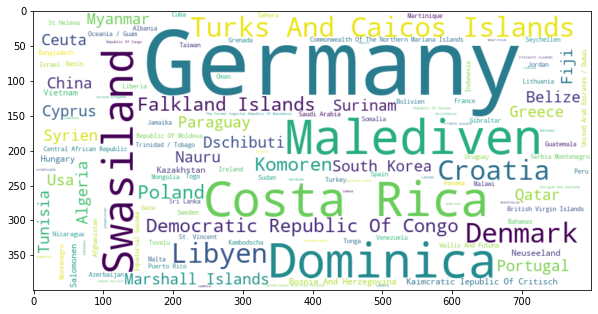

In [33]:
data = wc_plot_df.set_index('country').to_dict()['count']   # Need data in dic type to proceed further
wc = WordCloud(background_color="white",width=800, height=400, max_words=200).generate_from_frequencies(data)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
print("Pictorial representation that depicts countries selling the most vehicles")

## 2- In which of these years, we have sold a total of most vehicles?

In [34]:
# Grouping the data by years and units sold in each year respectively
vehicle_df.withColumn("production_date",year(vehicle_df.production_date))\
.groupBy("production_date").count()\
.orderBy("count",ascending=False).show()
print("Total number of units sold in each year")

+---------------+-----+
|production_date|count|
+---------------+-----+
|           2011|   53|
|           2012|   47|
|           2017|   43|
|           2015|   42|
|           2016|   37|
|           2013|   37|
|           2019|   34|
|           2018|   31|
|           2014|   31|
|           2020|   26|
|           2021|   17|
+---------------+-----+

Total number of units sold in each year


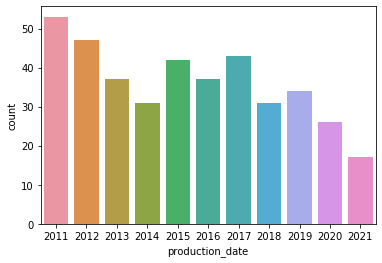

In [35]:
# Representing the results with a bar plot 
import seaborn 
bar_plt_df=vehicle_df.withColumn("production_date",year(vehicle_df.production_date))\
.groupBy("production_date").count()\
.orderBy("count",ascending=False).toPandas()
seaborn.barplot(x='production_date',y='count',data=bar_plt_df)

## 3- Which FIN is the first vehicle sold in terms of time?
 

In [36]:
# first vehicle stores the result as a list/first elelment of the dataframe after sorting with date 
first_vehicle=vehicle_df.sort("production_date").select("fin","production_date","country").first()
first_vehicle

Row(fin='WEB36004609995198', production_date=datetime.date(2011, 1, 26), country='Chad')

In [37]:
print("fin:'{0}' is the first vehicle corresponding to date:'{1}', shipped to '{2}'"\
      .format(first_vehicle[0],first_vehicle[1],first_vehicle[2]))

fin:'WEB36004609995198' is the first vehicle corresponding to date:'2011-01-26', shipped to 'Chad'


## 4- How many vehicles were sold between 01/01/2017 and 01/01/2021 with OM934, OM936, OM470 and OM471 engines ?

In [38]:
# task 2 part 4 (method 1)
test_df=vehicle_df.withColumn("engine_sales_code", vehicle_df["sales_code_array"].getItem(0))
test_df=test_df.join(engines_df,test_df.engine_sales_code == engines_df["Sales Code"],"inner")\
.select("fin","production_date","country","engine_sales_code","Code Description En")
#test_df.show()
result_df=test_df.filter((test_df["production_date"]>="2017-01-01") &\
              (test_df["production_date"]<="2021-01-01"))\
.where((test_df.engine_sales_code == "Z5B") | (test_df.engine_sales_code == "Z5C")\
      | (test_df.engine_sales_code == "Z5D") | (test_df.engine_sales_code == "Z5E"))
result_df.show(10)
result_df.count()

+-----------------+---------------+--------------------+-----------------+-------------------+
|              fin|production_date|             country|engine_sales_code|Code Description En|
+-----------------+---------------+--------------------+-----------------+-------------------+
|WEB93242568855045|     2019-09-08|             Germany|              Z5B|             OM 934|
|WEB46621125785635|     2018-01-29|              Libyen|              Z5D|             OM 470|
|WEB96465783638934|     2017-03-22|      Oceania / Guam|              Z5C|             OM 936|
|WDB53371429331330|     2017-02-20|              Panama|              Z5D|             OM 470|
|NMB71327410429524|     2019-04-24|Democratic Republ...|              Z5C|             OM 936|
|WEB75879323918209|     2020-01-10|              Greece|              Z5B|             OM 934|
|WDB85824751704234|     2018-09-06|                Oman|              Z5E|             OM 471|
|WEB36127895165833|     2019-04-07|             Ge

88

In [39]:
# Engines sold with respect to years b/w 2017 to 2021
result_df.groupBy(year(sales_codes_df["production_date"]).alias("Year"))\
.pivot("Code Description En")\
.count()\
.sort("Year")\
.show()

+----+------+------+------+------+
|Year|OM 470|OM 471|OM 934|OM 936|
+----+------+------+------+------+
|2017|     8|     6|     4|     7|
|2018|     7|     6|     6|     3|
|2019|     7|     6|     4|     7|
|2020|     2|     3|     8|     4|
+----+------+------+------+------+



In [40]:
# solution 2 task 2 part 4
sample_df=vehicle_df.filter((array_contains(vehicle_df.sales_code_array,'Z5B'))\
                            | (array_contains(vehicle_df.sales_code_array,'Z5C'))\
                            | (array_contains(vehicle_df.sales_code_array,'Z5D'))\
                            | (array_contains(vehicle_df.sales_code_array,'Z5E')))\
.where((vehicle_df["production_date"]>="2017-01-01") & (vehicle_df["production_date"]<="2021-01-01"))
sample_df.show()

+-----------------+---------------+--------------------+--------------------+
|              fin|production_date|             country|    sales_code_array|
+-----------------+---------------+--------------------+--------------------+
|WEB93242568855045|     2019-09-08|             Germany|[Z5B, M1I, R5N, Q...|
|WEB46621125785635|     2018-01-29|              Libyen|[Z5D, M2R, C6G, D...|
|WEB96465783638934|     2017-03-22|      Oceania / Guam|[Z5C, M2E, O1H, W...|
|WDB53371429331330|     2017-02-20|              Panama|[Z5D, M2N, W1H, Q...|
|NMB71327410429524|     2019-04-24|Democratic Republ...|[Z5C, M2F, B2C, V...|
|WEB75879323918209|     2020-01-10|              Greece|[Z5B, M1I, F6E, C...|
|WDB85824751704234|     2018-09-06|                Oman|[Z5E, M3B, J3Q, E...|
|WEB36127895165833|     2019-04-07|             Germany|[Z5D, M2S, E1M, X...|
|WDB66423310979449|     2018-06-29|         Afghanistan|[Z5E, M3C, S5P, D...|
|NMB79553907018186|     2017-10-30|   Trinidad / Tobago|[Z5E, M3

## 5- Which vehicles (FIN) were sold to New Zealand between 01/01/2017 and 01/01/2021 and with an OM936 engine?

In [41]:
result_df1=test_df.filter((test_df["production_date"]>="2017-01-01") &\
              (test_df["production_date"]<="2021-01-01") &\
              (test_df["country"]=="Neuseeland"))\
.where((test_df.engine_sales_code == "Z5B") | (test_df.engine_sales_code == "Z5C")\
      | (test_df.engine_sales_code == "Z5D") | (test_df.engine_sales_code == "Z5E"))
result_df1.show()
result_df1.count()

+-----------------+---------------+----------+-----------------+-------------------+
|              fin|production_date|   country|engine_sales_code|Code Description En|
+-----------------+---------------+----------+-----------------+-------------------+
|NMB26186144147288|     2019-06-01|Neuseeland|              Z5C|             OM 936|
+-----------------+---------------+----------+-----------------+-------------------+



1

In [42]:
# Solution 2 task 2 part 5
sample_df1=vehicle_df.filter(array_contains(vehicle_df.sales_code_array,'Z5C'))\
.where((vehicle_df["production_date"]>="2017-01-01") & (vehicle_df["production_date"]<="2021-01-01")\
      & (vehicle_df["country"]=="Neuseeland"))
sample_df1.show()
sample_df1.count()

+-----------------+---------------+----------+--------------------+
|              fin|production_date|   country|    sales_code_array|
+-----------------+---------------+----------+--------------------+
|NMB26186144147288|     2019-06-01|Neuseeland|[Z5C, M2D, T3P, Z...|
+-----------------+---------------+----------+--------------------+



1